In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
os.chdir('/content/drive/My Drive/Colab Notebooks/VisionLab/')
df = pd.read_csv('ozon.csv')
df.head()

,radiation,temperature,wind,ozone
0,190,67,7.4,41
1,118,72,8.0,36
2,149,74,12.6,12
3,313,62,11.5,18
4,299,65,8.6,23


## Section 1
80% of the data is used for training and the rest is reserved for test
predications are obtained using the following formula just as proved in the instructions.
$$
\beta = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T y →
\hat{y} = \mathbf{X}\beta
$$

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = df[['radiation', 'temperature', 'wind']]
y = df['ozone']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_with_intercept = np.c_[np.ones(X_train.shape[0]), X_train]

beta = np.linalg.inv(X_train_with_intercept.T @ X_train_with_intercept) @ X_train_with_intercept.T @ y_train

print(f"Model intercept: {beta[0]}")
print(f"Model coefficients: {beta[1:]}")

Model intercept: -60.992391089279444
Model coefficients: [ 0.06339674  1.6229136  -3.45349018]


Now the model is evaluated using both the train and the test data. Since the number of samples is insufficient, the loss over test can actually obtain a lower value than the training loss.

In [8]:
from sklearn.metrics import mean_squared_error

y_train_pred = X_train_with_intercept @ beta

mse_train = mean_squared_error(y_train, y_train_pred)
print(f"Mean Squared Error on training data: {mse_train:.2f}")

X_test_with_intercept = np.c_[np.ones(X_test.shape[0]), X_test]
y_test_pred = X_test_with_intercept @ beta

mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error on test data: {mse_test:.2f}")

Mean Squared Error on training data: 481.63
Mean Squared Error on test data: 245.17


Here, different levels of noise are added to the data, and the prediction results are monitored. Since the test data is new to the model, adding noise to it will introduce significantly more randomness to the accuracy, as data points jump to completely new locations.

The training loss, on the other hand, undergoes a steady increment.

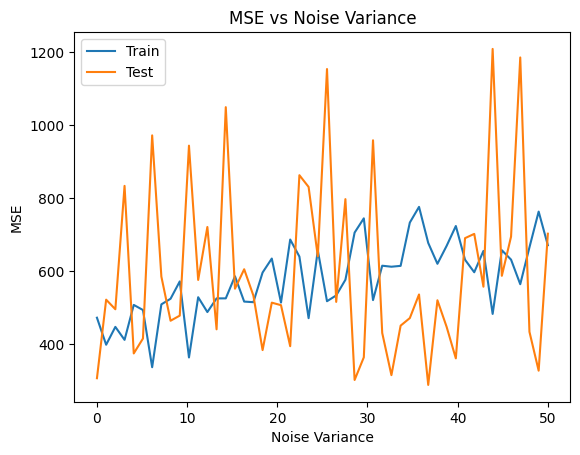

In [9]:
noise_vars = np.linspace(0, 50, 50)

test_error = []
train_error = []
for noise_var in noise_vars:
    noise = np.random.normal(0, np.sqrt(noise_var), X.shape)
    X_noise = X + noise
    X_train, X_test, y_train, y_test = train_test_split(X_noise, y, test_size=0.2)

    X_train_with_intercept = np.c_[np.ones(X_train.shape[0]), X_train]
    X_test_with_intercept = np.c_[np.ones(X_test.shape[0]), X_test]
    beta = np.linalg.inv(X_train_with_intercept.T @ X_train_with_intercept) @ X_train_with_intercept.T @ y_train

    y_train_pred = X_train_with_intercept @ beta
    y_test_pred = X_test_with_intercept @ beta

    train_error.append(mean_squared_error(y_train, y_train_pred))
    test_error.append(mean_squared_error(y_test, y_test_pred))

plt.plot(noise_vars, train_error, label='Train')
plt.plot(noise_vars, test_error, label='Test')
plt.title('MSE vs Noise Variance')
plt.xlabel('Noise Variance')
plt.ylabel('MSE')
plt.legend()

Now, we introduce the squared value of each feature as a set of new features and recreate the model. We observe an improvement in the prediction results. The reason is that this process has allowed our models to utilize more sophisticated relations between the features and the label, moving beyond the limitation of only linear relations.
$$
y = \sum_i \alpha x_i + \beta x_i^2
$$

In [ ]:
X = df[['radiation', 'temperature', 'wind']]
X['radiation_sq'] = df['radiation']**2
X['temperature_sq'] = df['temperature']**2
X['wind_sq'] = df['wind']**2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
print(f"Mean Squared Error on training data: {mse_train:.2f}")


y_test_pred = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error on test data: {mse_test:.2f}")

Mean Squared Error on training data: 301.07
Mean Squared Error on test data: 479.98


##Section 2
We begin by loading the video frames into memory, and then split the resulting dataset into training and test data.

In [ ]:
import cv2

base_path = '/content/drive/My Drive/Colab Notebooks/VisionLab/Cohn-Kanade/videos/surprise videos/'

X = []
y = []

subject_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

for subject_dir_name in subject_dirs:
    current_subject_path = os.path.join(base_path, subject_dir_name)

    image_files = [f for f in os.listdir(current_subject_path) if f.lower().endswith('.png')]

    count = len(image_files)

    X_i = []
    y_i = []
    for i, filename in enumerate(image_files):
        y_i.append(i / count) # This generates labels based on frame progression

        img_path = os.path.join(current_subject_path, filename)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Warning: Could not read image {img_path}. Skipping.")
            continue

        # FIX: Assign the result of cvtColor to a variable
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        X_i.append(gray_img.flatten()) # Flatten the grayscale image

    X.append(X_i)
    y.append(y_i)

In [ ]:
import itertools

# Flatten the list of lists of arrays into a single list of arrays
X_flat = list(itertools.chain.from_iterable(X))
# Flatten the list of lists of labels into a single list of labels
y_flat = list(itertools.chain.from_iterable(y))

# Convert the flattened lists to NumPy arrays
X_flat = np.array(X_flat)
y_flat = np.array(y_flat)

# Now perform the train-test split on the flattened arrays
# Using random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_flat, test_size=0.2, random_state=42)

Since there are too many features, the program is unable to calculate the model coefficients and crashes. For $n$ features, the computations required are on the order of $O(n^3)$ , which quickly exceeds the available computational resources (memory and/or time).

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
print(f"Mean Squared Error on training data: {mse_train:.2f}")


y_test_pred = model.predict(X_test)

mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error on test data: {mse_test:.2f}")

KeyboardInterrupt: 

We now decrease the image quality and reduce the number of features to $\frac{1}{16}$ of the original count.

In [ ]:
import cv2

base_path = '/content/drive/My Drive/Colab Notebooks/VisionLab/Cohn-Kanade/videos/surprise videos/'

X = []
y = []

subject_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

for subject_dir_name in subject_dirs:
    current_subject_path = os.path.join(base_path, subject_dir_name)

    image_files = [f for f in os.listdir(current_subject_path) if f.lower().endswith('.png')]

    count = len(image_files)

    X_i = []
    y_i = []
    for i, filename in enumerate(image_files):
        y_i.append(i / count)

        img_path = os.path.join(current_subject_path, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (img.shape[0]//4, img.shape[1]//4))
        X_i.append(img.flatten())

    X.append(X_i)
    y.append(y_i)

In [ ]:
# Flatten the list of lists of arrays into a single list of arrays
X_flat = list(itertools.chain.from_iterable(X))
# Flatten the list of lists of labels into a single list of labels
y_flat = list(itertools.chain.from_iterable(y))

# Convert the flattened lists to NumPy arrays
X_flat = np.array(X_flat)
y_flat = np.array(y_flat)

# Now perform the train-test split on the flattened arrays
# Using random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_flat, test_size=0.2, random_state=42)

We then rerun the model and obtain its parameters

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
print(f"Mean Squared Error on training data: {mse_train:.2f}")


y_test_pred = model.predict(X_test)

mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error on test data: {mse_test:.2f}")

Mean Squared Error on training data: 0.00
Mean Squared Error on test data: 0.02


### Evaluating Linear Regression with varying PCA Components

We'll now systematically evaluate the performance of the Linear Regression model by varying the number of principal components used for dimensionality reduction. This will help us understand the trade-off between model complexity and performance.

As observed, the loss over both the training and test sets decreases rapidly at first. This initial phase implies the model is underfitting and requires a higher dimensional feature space (more components) for more accurate prediction.

The test loss hits its minimum at `135` components and subsequently begins to rise slowly. The training loss, however, continues to decline. This divergence clearly indicates that the model is overfitting to the training data.

Hence, the optimal number of principal components is around `135`.

Evaluating Linear Regression with varying PCA components...
  Processing with 10 components...
  Processing with 20 components...
  Processing with 30 components...
  Processing with 40 components...
  Processing with 50 components...
  Processing with 60 components...
  Processing with 70 components...
  Processing with 80 components...
  Processing with 90 components...
  Processing with 100 components...
  Processing with 110 components...
  Processing with 120 components...
  Processing with 130 components...
  Processing with 140 components...
  Processing with 150 components...
  Processing with 160 components...
  Processing with 170 components...
  Processing with 180 components...
  Processing with 190 components...
  Processing with 200 components...
Evaluation complete.


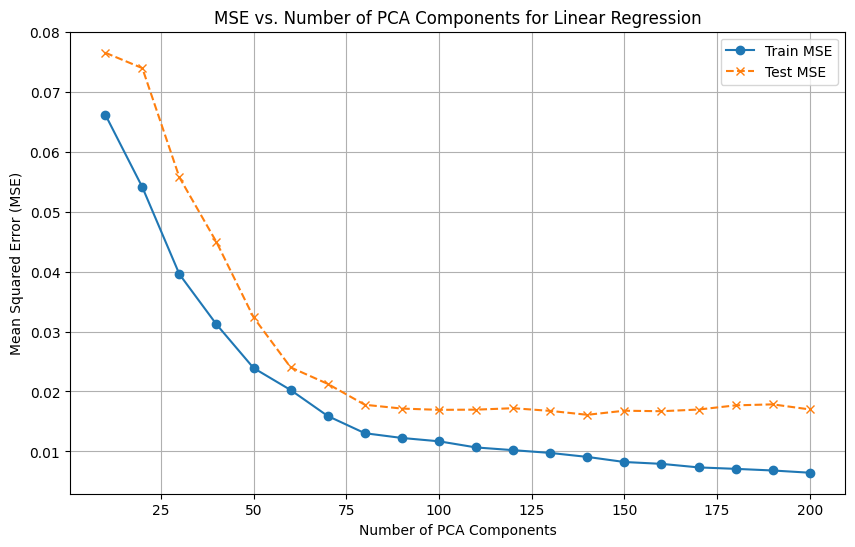

In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Define a range of PCA components to test
n_components_range = np.arange(10, 321, 40) # From 10 to 200, step of 10

train_mse_scores = []
test_mse_scores = []

print("Evaluating Linear Regression with varying PCA components...")
for n_comp in n_components_range:
    print(f"  Processing with {n_comp} components...")
    # Apply PCA
    pca = PCA(n_components=n_comp)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Train Linear Regression model
    model = LinearRegression()
    model.fit(X_train_pca, y_train)

    # Calculate training MSE
    y_train_pred = model.predict(X_train_pca)
    mse_train = mean_squared_error(y_train, y_train_pred)
    train_mse_scores.append(mse_train)

    # Calculate test MSE
    y_test_pred = model.predict(X_test_pca)
    mse_test = mean_squared_error(y_test, y_test_pred)
    test_mse_scores.append(mse_test)

print("Evaluation complete.")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, train_mse_scores, label='Train MSE', marker='o', linestyle='-')
plt.plot(n_components_range, test_mse_scores, label='Test MSE', marker='x', linestyle='--')
plt.title('MSE vs. Number of PCA Components for Linear Regression')
plt.xlabel('Number of PCA Components')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()